In [1]:
import os
import argparse
from ml_collections import ConfigDict
import yaml
import time

import copy
import numpy as np
import torch
from torch import optim
from torch.utils.data import DataLoader
from torch_geometric.transforms import Compose
from tqdm import tqdm
import wandb
import numpy as np
import random

from data.data_preprocess import HeteroAddLaplacianEigenvectorPE, SubSample, SubSample_pad
from data.dataset import LPDataset
from data.utils import args_set_bool, collate_fn_ip
from models.hetero_gnn import TripartiteHeteroGNN, TripartiteHeteroGNN_, TripartiteHeteroGNN_new, BipartiteHeteroGNN
from trainer_ import Trainer

In [2]:
if wandb.run is not None:
    print('wandb running')
else:
    print('wandb not running')

wandb not running


In [3]:
# 2*ipm_steps/num_conv_layers = outer loop
# num_conv_layers = inner loop
var_dict = {
            "weight_decay": 0,
            "micro_batch": 16,         # oringal: 4, 
            "batchsize": 32,          # oringal: 128,
            "hidden": 180, 
            "num_conv_layers": 2,     # oringinal: 8,  
            "num_pred_layers": 4, 
            "num_mlp_layers": 4, 
#             "share_lin_weight": 'false', 
            "share_lin_weight": True, 
#             "conv_sequence": 'ceov', 
            "conv_sequence": 'cov', 
            "loss_weight_x": 1.0, 
            "loss_weight_obj": 3.43, 
            "loss_weight_cons": 5.8,     # oringinal: 5.8
            "losstype": 'l2',
            "runs": 3,
            "lappe": 0, 
            "conv": 'gcnconv', 
            "epoch": 50,    # oringal: 500
#             "ipm_alpha": 0.35,
            "ipm_alpha": 0.7,
    
            "ipm_steps": 16,       # 8 for supervising every mlp layer, 1 for supervising last layer
    
            "dropout": 0,
#             "share_conv_weight": 'false',        # default: false   
            "share_conv_weight": True,        # default: false  
#             "use_norm": 'true',
#             "use_res": 'false',  
            "use_norm": True,
            "use_res": True,  
            "lr": 1.e-5,     # original: 1.e-3
            "weight_decay": 0
            }

In [4]:
# wandb.init(project='reallocation_harp',
#            config=var_dict,
#            entity="fzhou")

In [5]:
if wandb.run is not None:
    print('wandb running')
else:
    print('wandb not running')

wandb not running


In [6]:
# -Ax+b<=-1
# Use TripartitionGNN

trainleq1_ins = 'trainleq1_abilene' 
validleq1_ins = 'validleq1_abilene'
testleq1_ins = 'testleq1_abilene'
ipm = 16

testleq1_dataset = LPDataset('raw',
                    extra_path=f'{1}restarts_'
                                     f'{0}lap_'
                                     f'{ipm}steps'
                                     f'{"_upper_" + str(testleq1_ins)}',
                    upper_bound=1,
                    rand_starts=1,
                    pre_transform=Compose([HeteroAddLaplacianEigenvectorPE(k=0),
                                                 SubSample(ipm)]))

test_loader = DataLoader(testleq1_dataset,
                        batch_size=var_dict['batchsize'],
                        shuffle=False,
                        num_workers=1,
                        collate_fn=collate_fn_ip)

In [7]:
len(testleq1_dataset)/var_dict["batchsize"], len(testleq1_dataset)%var_dict["batchsize"]

(57.5, 16)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
#### test exact number of iteration model

seed = 2026      # 2025, 2026, 2027, 2028 
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

path = 'logs/o16i2_train_abilene_leq1_2026/run0/43_best_model.pt'
path = 'logs/o16i2_train_abilene_leq1_2026/run0/49_model.pt'


model = TripartiteHeteroGNN_(ipm_steps=var_dict['ipm_steps'],
                                conv=var_dict['conv'],
                                in_shape=2,
                                pe_dim=var_dict['lappe'],
                                hid_dim=var_dict['hidden'],
                                num_conv_layers=var_dict['num_conv_layers'],
                                num_pred_layers=var_dict['num_pred_layers'],
                                num_mlp_layers=var_dict['num_mlp_layers'],
                                dropout=var_dict['dropout'],
                                share_conv_weight=var_dict['share_conv_weight'],
                                share_lin_weight=var_dict['share_lin_weight'],
                                use_norm=var_dict['use_norm'],
                                use_res=var_dict['use_res'],
                                conv_sequence=var_dict['conv_sequence']).to(device)


trainer = Trainer(device,
                  'primal+objgap+constraint',
                  var_dict['losstype'],
                  var_dict['micro_batch'],
                  var_dict['ipm_steps'],
                  var_dict['ipm_alpha'],
                  loss_weight={'primal': var_dict['loss_weight_x'],
                               'objgap': var_dict['loss_weight_obj'],
                               'constraint': var_dict['loss_weight_cons']})

model.load_state_dict(torch.load(path))

num_pair = 132     # abilene (12*11, also the number of the first set of constraints Ax=1)
k = 8              # k-shortest path
with torch.no_grad():

    objs_gap, cons_gap, objs_nocgap, norm_mlus, mlus = trainer.eval_metrics_harpleq1(k, num_pair, var_dict['batchsize'], test_loader, model)

test_objgap = objs_gap[:, -1].mean()
test_consgap = cons_gap[:, -1].mean()
test_objgap_nocon = objs_nocgap[:, -1].mean()
test_norm_mlu = norm_mlus[:, -1].mean()
test_mlu = mlus[:, -1].mean()

print(test_objgap, test_consgap, test_objgap_nocon, test_norm_mlu, test_mlu)

num_1stcon, num_2ndcon: 132 30
a_row_idx torch.Size([960])
a_col_idx torch.Size([33792])
a_row, a_col, a_val torch.Size([192624]) torch.Size([192624]) torch.Size([192624])
keep_2ndcon torch.Size([158832])
a_row, a_col, a_val torch.Size([158832]) torch.Size([158832]) torch.Size([158832])
remove_lastcol torch.Size([157872])
a_row, a_col, a_val torch.Size([157872]) torch.Size([157872]) torch.Size([157872])
vals[:, -1] torch.Size([33824])
MLU tensor([4.3711, 4.3512, 4.1295, 4.2760, 4.3236, 4.3565, 4.2597, 4.2759, 4.2671,
        4.3437, 4.3711, 4.1916, 4.0941, 4.0040, 4.0322, 4.2008, 4.3084, 4.2747,
        4.2997, 4.3262, 4.6239, 4.2872, 4.2540, 4.2852, 4.1628, 4.0931, 3.9615,
        3.7897, 3.8966, 4.0029, 3.8785, 3.9339])
OPT tensor([0.3501, 0.3500, 0.3292, 0.3380, 0.3406, 0.3416, 0.3367, 0.3415, 0.3416,
        0.3462, 0.3525, 0.3440, 0.3392, 0.3289, 0.3373, 0.3407, 0.3567, 0.3466,
        0.3402, 0.3489, 0.3638, 0.3443, 0.3441, 0.3475, 0.3418, 0.3309, 0.3239,
        0.3104, 0.3122, 

KeyboardInterrupt: 

In [ ]:
a.shape

In [ ]:
A = torch.tensor([[1, 0, 0, 0, 3, 8], 
                  [0, 4, 5, 0, 0, 0], 
                  [2, 9, 7, 0, 0, 0]])
x = torch.tensor([2, 4, 4, 3, 4, 3])

In [22]:
torch.matmul(A, x)

tensor([38, 36, 68])

In [26]:
a_row = torch.tensor([0, 0, 0, 1, 1, 2, 2, 2])
a_col = torch.tensor([0, 4, 5, 1, 2, 0, 1, 2])
a_val = torch.tensor([1, 3, 8, 4, 5, 2, 9, 7])

In [27]:
from torch_scatter import scatter
scatter(x[a_col] * a_val, a_row, reduce='sum', dim=0)

tensor([38, 36, 68])

In [ ]:
# harp average loss: 1.008026 

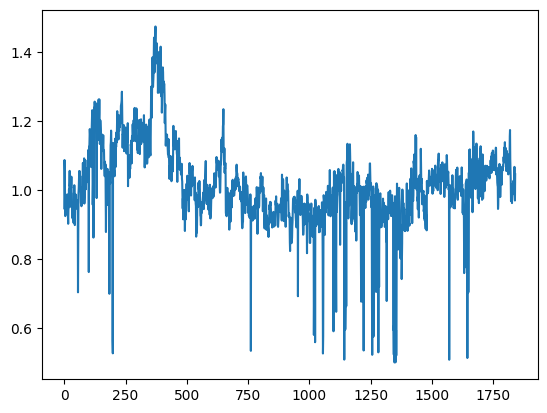

In [18]:
import matplotlib.pyplot as plt
import numpy as np


plt.plot(norm_mlus[:, -1])
plt.show()

In [20]:
34.84118151664734/1840

0.018935424737308335